In [1]:
import sys 
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)) 
def softmax(x, axis=-1):
    # Subtract the max value for numerical stability
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

num_classes=2
word2vec_len = 31 
num_phrases = 17
words_per_phrase = 13 
dk = 15
dv = 15
num_heads=5 
 
 
inputs = np.random.rand(num_phrases,words_per_phrase, word2vec_len)
target = softmax(np.random.rand(num_phrases,num_classes))

Q = np.random.rand(word2vec_len, dk) / np.sqrt(word2vec_len)
K = np.random.rand(word2vec_len, dk) / np.sqrt(word2vec_len)
V = np.random.rand(word2vec_len, dv) / np.sqrt(word2vec_len)
Q.shape,K.shape,V.shape


((31, 15), (31, 15), (31, 15))

In [2]:
inputs.shape

(17, 13, 31)

In [3]:
# Qval = np.matmul(inputs, Q)
# print("Qval.shape: ",Qval.shape,len(Qval))

# Kval = np.matmul(inputs, K)
# print("Kval.shape: ",Kval.shape,len(Kval))
 
# Vval =np.matmul(inputs, V)
# print("Vval.shape: ",Vval.shape,len(Vval))






Qval = np.swapaxes(np.array_split(np.matmul(inputs, Q),num_heads,axis=2), 0, 1)
print("Qval.shape: ",Qval[0].shape,len(Qval))

Kval = np.swapaxes(np.array_split(np.matmul(inputs, K),num_heads,axis=2), 0, 1)
print("Kval.shape: ",Kval[0].shape,len(Kval))


Vval = np.swapaxes(np.array_split(np.matmul(inputs, V),num_heads,axis=2), 0, 1)
print("Vval.shape: ",Vval[0].shape,len(Vval))

 
QKscaled = np.matmul(Qval, np.transpose(Kval, (0, 1, 3, 2))) / np.sqrt(dk)
 
QKscaled

 
Attention_weights = softmax(QKscaled)
print("Attention_weights shape:",Attention_weights.shape)

Attention = np.matmul(Attention_weights, Vval)
print("Attention shape:",Attention.shape)

phrase_representation = np.mean(Attention, axis=2).reshape(num_phrases,dv)
print("Concat Phrase Representation:",phrase_representation.shape)





linearlayer= np.random.rand(dv, num_classes)   
linear_bias = np.random.rand(num_classes)
Sigma_Zout=softmax(np.matmul(phrase_representation, linearlayer) + linear_bias)
Sigma_Zout
import numpy as np

 
def cross_entropy_loss(predictions, target): 
    batch_loss = -np.sum(target * np.log(predictions + 1e-8), axis=1)
    return np.mean(batch_loss) 
 

loss = cross_entropy_loss(Sigma_Zout, target)
print("Cross-Entropy Loss: ",loss)

Qval.shape:  (5, 13, 3) 17
Kval.shape:  (5, 13, 3) 17
Vval.shape:  (5, 13, 3) 17
Attention_weights shape: (17, 5, 13, 13)
Attention shape: (17, 5, 13, 3)
Concat Phrase Representation: (17, 15)
Cross-Entropy Loss:  1.135807654901122


In [18]:
dLoss_dSigma_Zout =Sigma_Zout - np.stack(target)
dLoss_dSigma_Zout

# Gradient for linear layer and bias
d_linear = np.dot(dLoss_dSigma_Zout.T, phrase_representation).T
d_bias =  np.sum(dLoss_dSigma_Zout, axis=0)
d_linear,d_bias


# Gradient for phrase representation
d_phrase_rep = np.dot(dLoss_dSigma_Zout, linearlayer.T)
d_phrase_rep.shape
dL_dA = np.array([np.outer(np.ones(inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])])  / inputs.shape[1]
dL_dA = np.swapaxes(np.array(np.array_split(dL_dA,num_heads,axis=2)), 0, 1)
dL_dA 


softmax_derivative = Attention_weights*(1 - Attention_weights)


# Gradient for V
d_Vval=np.matmul(np.transpose(dL_dA,(0,1,3,2)), Attention_weights) 
dLoss_dV = np.concatenate(np.mean(np.matmul(d_Vval,inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])),axis=0),axis=0).T
dLoss_dV

# Gradient for Q
dLoss_dQ=np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval@np.transpose(Vval,(0,1,3,2))@inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])
dLoss_dQ=np.concatenate(np.mean(dLoss_dQ,axis=0),axis=0).T
dLoss_dQ.shape

# Gradient for K
dLoss_dK=np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Qval@np.transpose(Vval,(0,1,3,2))@inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])
dLoss_dK=np.concatenate(np.mean(dLoss_dK,axis=0),axis=0).T
dLoss_dK.shape

clip_value = 15.0
dLoss_dQ = np.clip(dLoss_dQ, -clip_value, clip_value)
dLoss_dK = np.clip(dLoss_dK, -clip_value, clip_value)
dLoss_dV = np.clip(dLoss_dV, -clip_value, clip_value)
d_linear = np.clip(d_linear, -clip_value, clip_value)
d_bias = np.clip(d_bias, -clip_value, clip_value)
learning_rate=0.001
Q -= learning_rate * dLoss_dQ
K -= learning_rate * dLoss_dK
V -= learning_rate * dLoss_dV
linearlayer -= learning_rate * d_linear
linear_bias -= learning_rate * d_bias

In [58]:
softmax_derivative = Attention_weights*(1 - Attention_weights)
print("softmax_derivative.shape: ", softmax_derivative.shape)

softmax_derivative.shape:  (25, 4, 7, 7)


\\[ 
 \frac{Inputs \cdot K_{val}^T}{\sqrt{d_k}}
\\] 

In [52]:
print("inputs.shape: ", inputs.shape)
print("Kval.shape: ", Kval.shape)
print("Q.shape: ", Q.shape,"K.shape: ",K.shape)
print("Vval.shape: ", Vval.shape ) 

inputs.shape:  (25, 7, 15)
Kval.shape:  (25, 4, 7, 2)
Q.shape:  (15, 8) K.shape:  (15, 8)
Vval.shape:  (25, 4, 7, 2)


\\[ 
 K_{val}^T=(Inputs \cdot K)^T = K^T \cdot I^T
\\] 

In [22]:
I=np.repeat(inputs, num_head, axis=0).reshape(num_phrases,num_head,words_per_phrase,word2vec_len)
I.shape

(9, 2, 5, 6)

In [55]:
dLoss_dQ=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dQ=np.transpose(np.mean(dLoss_dQ,axis=0),(0,2,1)).shape

NameError: name 'I' is not defined

In [24]:
Q.shape

(2, 6, 3)

In [25]:
np.transpose(I,(0,1,3,2)).shape

(9, 2, 6, 5)

In [26]:
np.transpose(Vval,(0,1,3,2)).shape

(9, 2, 4, 5)

In [31]:
I=np.repeat(inputs, num_head, axis=0).reshape(num_phrases,num_head,words_per_phrase,word2vec_len)

dLoss_dQ=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dQ=np.transpose(np.mean(dLoss_dQ,axis=0),(0,2,1)) 

dLoss_dK=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Qval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dK=np.transpose(np.mean(dLoss_dK,axis=0),(0,2,1)) 

In [32]:
# Update weights
learning_rate=0.001
Q -= learning_rate * dLoss_dQ
K -= learning_rate * dLoss_dK
V -= learning_rate * dLoss_dV
linearlayer -= learning_rate * d_linear
linear_bias -= learning_rate * d_bias

In [30]:
dLoss_dQ

(2, 6, 3)

((1668, 70, 300), (557, 70, 300), (1668, 5), (557, 5))

In [4]:
import sys
sys.path.append('c:\\python312\\lib\\site-packages')
from sklearn.model_selection import train_test_split 
import pickle
import spacy
import numpy as np 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from PIL import Image
import io
from IPython.display import display 
import cupy as cp

In [6]:
df=pd.read_csv("data/bbc-text.csv")
nlp = spacy.load('en_core_web_lg')
with open('data/InputProcessed.pkl', 'rb') as f:
    X = pickle.load(f)

y = np.array(pd.get_dummies(df["category"], dtype=int))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((1668, 70, 300), (557, 70, 300), (1668, 5), (557, 5))

In [7]:
X_train.shape

(1668, 70, 300)

In [8]:
class QKVMultiHeadsAttentionClassifier:
    def __init__(self, word_len, words_per_phrase, num_heads, batch_size, dk, dv, num_classes, validation_split=0.0,
                 momentum_beta=0.9,
                 rmsprop_beta=0.98,
                 epsilon=0.00000001):

        self.word_len = word_len
        self.batch_size = batch_size
        self.dk = dk
        self.dv = dv
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.words_per_phrase = words_per_phrase
        self.validation_split = validation_split
        self.validation_scores = []
        self.training_losses = []
        self.MomQ = 0
        self.MomK = 0
        self.MomV = 0
        self.MomLy = 0
        self.MomB = 0
        self.RMSPQ = 0
        self.RMSPK = 0
        self.RMSPV = 0
        self.RMSPLy= 0
        self.RMSPB = 0
        self.momentum_beta=momentum_beta
        self.rmsprop_beta=rmsprop_beta
        self.epsilon=epsilon
        self.iterations=0
        

        
        # Initialize weights with Xavier/Glorot initialization
        self.Q = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01
        self.K = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01
        self.V = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01

        # Initialize linear layer weights
        self.linearlayer = np.random.randn(self.dv, self.num_classes) / np.sqrt(self.dk)
        self.linear_bias = np.zeros(self.num_classes)

    def softmax(self, x, axis=-1):
        x = np.clip(x, -1e4, 1e4)  # Clip for numerical stability
        e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        softmax_result = e_x / np.sum(e_x, axis=axis, keepdims=True)
        # print("Softmax result shape:", softmax_result.shape)
        return softmax_result

    def cross_entropy_loss(self, predictions, target):
        # Cross-entropy loss for a batch of predictions and targets
        batch_loss = -np.sum(target * np.log(predictions + 1e-9), axis=1)
        mean_loss = np.mean(batch_loss)
        # print("Cross-entropy loss:", mean_loss)
        return mean_loss
    def load_train_validation_splits(self, X_train, y_train):
        X_train_validation = X_train[0:round(self.validation_split * len(X_train))]
        y_train_validation = y_train[0:round(self.validation_split * len(y_train))]
        X_train = X_train[round(self.validation_split * len(X_train)):]
        y_train = y_train[round(self.validation_split * len(y_train)):]
        return [X_train, X_train_validation, y_train, y_train_validation]

    def pad_sequences(self, sequences, max_len):
        padded_sequences = np.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

    def training_validation(self, X_validation, y_validation, current_loss):
        # Pad validation sequences
        X_validation = self.pad_sequences(X_validation, self.words_per_phrase)

        # Make predictions
        predictions = self.predict(X_validation)

        # Convert predictions to class labels
        y_pred = np.argmax(predictions, axis=1)

        # Convert one-hot encoded true labels to class labels
        y_true = np.argmax(y_validation, axis=1)

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average="weighted")
        print("Validation F1 score: ", f1)

        # Append current F1 score and loss
        self.validation_scores.append(f1)
        self.training_losses.append(current_loss)

        # Create an Epoch column
        epochs = list(range(1, len(self.validation_scores) + 1))

        # Create DataFrame for plotting
        data = pd.DataFrame({
            'Epoch': epochs,
            'F1 Score': self.validation_scores,
            'Loss': self.training_losses
        })

        # Plot F1 score and Loss
        self.image = plt.figure(figsize=(10, 6))

        # F1 score line plot
        sns.lineplot(x='Epoch', y='F1 Score', data=data, label='F1 Score', marker='o')

        # Loss line plot on the same axes
        sns.lineplot(x='Epoch', y='Loss', data=data, label='Loss', marker='o')

        # Set plot labels and title
        plt.title('F1 Score and Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score / Loss')

        # Show legend and grid
        plt.legend()
        plt.grid(True)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Load the image from BytesIO object into a PIL Image
        self.image = Image.open(buf)

        plt.close()
        # Display the plot
        # self.image.show()

    
    def MultiHeadsAttention(self, Inputs):
        self.Qval = np.swapaxes(np.array_split(np.matmul(Inputs, self.Q),self.num_heads,axis=2), 0, 1)
        self.Kval = np.swapaxes(np.array_split(np.matmul(Inputs, self.K),self.num_heads,axis=2), 0, 1)
        self.Vval = np.swapaxes(np.array_split(np.matmul(Inputs, self.V),self.num_heads,axis=2), 0, 1)
        # print("Qval shape:", self.Qval.shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)

        QKscaled = np.matmul(self.Qval, np.transpose(self.Kval, (0, 1, 3, 2))) / np.sqrt(self.dk)
        # print("QKscaled shape:", QKscaled.shape)

        self.Attention_weights = self.softmax(QKscaled)
        # print("Attention_weights shape:", self.Attention_weights.shape)

        Attention_output = np.matmul(self.Attention_weights, self.Vval)
        # print("Attention output shape:", Attention_output.shape)

        return Attention_output

    def LinearLayer(self):
        output = np.matmul(self.phrase_representation, self.linearlayer) + self.linear_bias
        # print("Linear layer output shape:", output.shape)
        return output

    def forward(self, Inputs):

        Attention = self.MultiHeadsAttention(Inputs)

        #print("Attention shape:", Attention.shape)
        #print("Attention mean shape:", np.mean(Attention, axis=2).shape)
        self.phrase_representation = np.mean(Attention, axis=2).reshape(Inputs.shape[0],self.dv)
        

        Zout = self.LinearLayer()

        Sigma_Zout = self.softmax(Zout)
        # print("Sigma_Zout shape:", Sigma_Zout.shape)

        return Sigma_Zout

    def BackPropagation(self, dLoss_dSigma_Zout, Inputs):

        # Gradient for linear layer
        dlinear_dW = np.dot(dLoss_dSigma_Zout.T, self.phrase_representation).T
        # print("dlinear_dW shape:", dlinear_dW.shape)

        # Gradient for bias
        d_bias = np.sum(dLoss_dSigma_Zout, axis=0)
        # print("d_bias shape:", d_bias.shape)

        # Gradient for phrase representation
        d_phrase_rep = np.dot(dLoss_dSigma_Zout, self.linearlayer.T)
        # print("d_phrase_rep shape:", d_phrase_rep.shape)

        # Gradient for attention
        dL_dA = np.array(
            [np.outer(np.ones(Inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])]) / \
                Inputs.shape[1]
        dL_dA = np.swapaxes(np.array(np.array_split(dL_dA, self.num_heads, axis=2)), 0, 1)
        # print("dL_dA shape:", dL_dA.shape)

        # Gradient for V
        d_Vval = np.matmul(np.transpose(dL_dA, (0, 1, 3, 2)), self.Attention_weights)
        dLoss_dV = np.concatenate(np.mean(np.matmul(d_Vval,Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])),axis=0),axis=0).T
        # print("dLoss_dV shape:", dLoss_dV.shape)

        # Gradient of softmax
        dAttention_dSoftmax = self.Attention_weights * (1 - self.Attention_weights)
        # print("dAttention_dSoftmax shape:", dAttention_dSoftmax.shape)


        # Compute dLoss_dQ
        dLoss_dQ = np.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Kval @ np.transpose(self.Vval, (
        0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dQ = np.concatenate(np.mean(dLoss_dQ, axis=0), axis=0).T
        # print("dLoss_dQ shape:", dLoss_dQ.shape)

        # Gradient of K
        dLoss_dK = np.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Qval @ np.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dK = np.concatenate(np.mean(dLoss_dK, axis=0), axis=0).T
        # print("dLoss_dK shape:", dLoss_dK.shape)

        # Gradient clipping
        clip_value = 150.0
        dLoss_dQ = np.clip(dLoss_dQ, -clip_value, clip_value)
        dLoss_dK = np.clip(dLoss_dK, -clip_value, clip_value)
        dLoss_dV = np.clip(dLoss_dV, -clip_value, clip_value)
        dlinear_dW = np.clip(dlinear_dW, -clip_value, clip_value)
        d_bias = np.clip(d_bias, -clip_value, clip_value)

        self.UpdateParams(dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias)

    def UpdateParams(self, dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias):
        self.iterations += 1
           # Set a minimum learning rate to avoid it going too low
        # Linear learning rate decay
        
        lr = self.learning_rate * (1 - self.iterations / self.total_iterations)
        self.learning_rate = max(lr, 0.001)  # Prevent learning rate from becoming too small
        
        
        # Update biased first moments (momentum)
        self.MomQ = (self.momentum_beta * self.MomQ + (1 - self.momentum_beta) * dLoss_dQ)
        self.MomK = (self.momentum_beta * self.MomK + (1 - self.momentum_beta) * dLoss_dK)
        self.MomV = (self.momentum_beta * self.MomV + (1 - self.momentum_beta) * dLoss_dV)
        self.MomLy = (self.momentum_beta * self.MomLy + (1 - self.momentum_beta) * dlinear_dW)
        self.MomB = (self.momentum_beta * self.MomB + (1 - self.momentum_beta) * d_bias)
    
        # Update biased second moments (variance)
        self.RMSPQ = (self.rmsprop_beta * self.RMSPQ + (1 - self.rmsprop_beta) * dLoss_dQ * dLoss_dQ)
        self.RMSPK = (self.rmsprop_beta * self.RMSPK + (1 - self.rmsprop_beta) * dLoss_dK * dLoss_dK)
        self.RMSPV = (self.rmsprop_beta * self.RMSPV + (1 - self.rmsprop_beta) * dLoss_dV * dLoss_dV)
        self.RMSPLy = (self.rmsprop_beta * self.RMSPLy + (1 - self.rmsprop_beta) * dlinear_dW * dlinear_dW)
        self.RMSPB = (self.rmsprop_beta * self.RMSPB + (1 - self.rmsprop_beta) * d_bias * d_bias)
    
        # Bias correction for first moments
        MomQ_corrected = self.MomQ / (1 - self.momentum_beta ** self.iterations)
        MomK_corrected = self.MomK / (1 - self.momentum_beta ** self.iterations)
        MomV_corrected = self.MomV / (1 - self.momentum_beta ** self.iterations)
        MomLy_corrected = self.MomLy / (1 - self.momentum_beta ** self.iterations)
        MomB_corrected = self.MomB / (1 - self.momentum_beta ** self.iterations)
    
        # Bias correction for second moments
        RMSPQ_corrected = self.RMSPQ / (1 - self.rmsprop_beta ** self.iterations)
        RMSPK_corrected = self.RMSPK / (1 - self.rmsprop_beta ** self.iterations)
        RMSPV_corrected = self.RMSPV / (1 - self.rmsprop_beta ** self.iterations)
        RMSPLy_corrected = self.RMSPLy / (1 - self.rmsprop_beta ** self.iterations)
        RMSPB_corrected = self.RMSPB / (1 - self.rmsprop_beta ** self.iterations)
    
        # Update parameters using bias-corrected moments
        self.Q -= self.learning_rate * MomQ_corrected / (np.sqrt(RMSPQ_corrected) + self.epsilon)
        self.K -= self.learning_rate * MomK_corrected / (np.sqrt(RMSPK_corrected) + self.epsilon)
        self.V -= self.learning_rate * MomV_corrected / (np.sqrt(RMSPV_corrected) + self.epsilon)
        self.linearlayer -= self.learning_rate * MomLy_corrected / (np.sqrt(RMSPLy_corrected) + self.epsilon)
        self.linear_bias -= self.learning_rate * MomB_corrected / (np.sqrt(RMSPB_corrected) + self.epsilon)

         



    def train(self, X_train, y_train, num_epochs, learning_rate=0.01):
        
        self.learning_rate = learning_rate
        X_train = self.pad_sequences(X_train, self.words_per_phrase)

        if self.validation_split > 0:
            X_train, X_train_validation, y_train, y_train_validation = train_test_split(
                X_train, y_train, test_size=self.validation_split, random_state=42)
            print("Training starting:")
            print("X_train samples: ", X_train.shape[0])
            print("X_train_validation samples", X_train_validation.shape[0], "\n")

        
        self.total_iterations = num_epochs*(len(X_train) // self.batch_size)
        for epoch in range(num_epochs):
            self.iterations=0
            total_loss = 0

            num_batches_per_epoch = len(X_train) // self.batch_size

            for i in tqdm(range(num_batches_per_epoch), desc=f"Epoch {epoch + 1}/{num_epochs}"):
                
                
                
                start = i * self.batch_size
                end = start + self.batch_size
                
                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                yi = self.forward(X_batch)

                Loss = self.cross_entropy_loss(yi, y_batch)
                total_loss += Loss

                dLoss_dSigma_Zout = yi - y_batch

                self.BackPropagation(dLoss_dSigma_Zout, X_batch)

                
            
            if self.validation_split > 0:
                self.training_validation(X_train_validation, y_train_validation, Loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {(total_loss / num_batches_per_epoch):.4f}, learning rate: {self.learning_rate}")

    def predict(self, X):
        X = self.pad_sequences(X, self.words_per_phrase)
        return self.forward(X)

In [9]:
 

word_len = 300
max_words_per_phrase=100
dk = 32
dv = 32
batch_size = 64
num_classes = 5
num_head=8

 


#validation_split
model = QKVMultiHeadsAttentionClassifier(word_len, max_words_per_phrase,num_head, batch_size, dk, dv, num_classes,validation_split=0.1)
model.train(X_train, y_train, num_epochs=10, learning_rate=0.01)

Training starting:
X_train samples:  1501
X_train_validation samples 167 



Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.64it/s]


Validation F1 score:  0.827796045884579
Epoch 1/10, Loss: 1.3080, learning rate: 0.002884903119896506


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.48it/s]


Validation F1 score:  0.9043912175648703
Epoch 2/10, Loss: 0.4610, learning rate: 0.001


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.57it/s]


Validation F1 score:  0.8864349998999885
Epoch 3/10, Loss: 0.3722, learning rate: 0.001


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.60it/s]


Validation F1 score:  0.9102065717247307
Epoch 4/10, Loss: 0.3311, learning rate: 0.001


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.60it/s]


Validation F1 score:  0.9221089846450888
Epoch 5/10, Loss: 0.3048, learning rate: 0.001


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.76it/s]


Validation F1 score:  0.8911004793416258
Epoch 6/10, Loss: 0.2939, learning rate: 0.001


Epoch 7/10:   9%|██████▏                                                                | 2/23 [00:01<00:10,  1.92it/s]


KeyboardInterrupt: 

In [35]:
import cupy

class QKVMultiHeadsAttentionClassifier:
    def __init__(self, word_len, words_per_phrase, num_heads, batch_size, dk, dv, num_classes, validation_split=0.0,
                 momentum_beta=0.9,
                 rmsprop_beta=0.98,
                 epsilon=0.00000001):

        self.word_len = word_len
        self.batch_size = batch_size
        self.dk = dk
        self.dv = dv
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.words_per_phrase = words_per_phrase
        self.validation_split = validation_split
        self.validation_scores = []
        self.training_losses = []
        self.MomQ = 0
        self.MomK = 0
        self.MomV = 0
        self.MomLy = 0
        self.MomB = 0
        self.RMSPQ = 0
        self.RMSPK = 0
        self.RMSPV = 0
        self.RMSPLy = 0
        self.RMSPB = 0
        self.momentum_beta = momentum_beta
        self.rmsprop_beta = rmsprop_beta
        self.epsilon = epsilon
        self.iterations = 0

        # Initialize weights with Xavier/Glorot initialization
        self.Q = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01
        self.K = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01
        self.V = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01

        # Initialize linear layer weights
        self.linearlayer = cupy.random.randn(self.dv, self.num_classes) / cupy.sqrt(self.dk)
        self.linear_bias = cupy.zeros(self.num_classes)

    def softmax(self, x, axis=-1):
        x = cupy.clip(x, -1e4, 1e4)  # Clip for numerical stability
        e_x = cupy.exp(x - cupy.max(x, axis=axis, keepdims=True))
        softmax_result = e_x / cupy.sum(e_x, axis=axis, keepdims=True)
        # print("Softmax result shape:", softmax_result.shape)
        return softmax_result

    def cross_entropy_loss(self, predictions, target):
        # Cross-entropy loss for a batch of predictions and targets
        batch_loss = -cupy.sum(target * cupy.log(predictions + 1e-9), axis=1)
        mean_loss = cupy.mean(batch_loss)
        # print("Cross-entropy loss:", mean_loss)
        return mean_loss

    def load_train_validation_splits(self, X_train, y_train):
        X_train_validation = X_train[0:round(self.validation_split * len(X_train))]
        y_train_validation = y_train[0:round(self.validation_split * len(y_train))]
        X_train = X_train[round(self.validation_split * len(X_train)):]
        y_train = y_train[round(self.validation_split * len(y_train)):]
        return [X_train, X_train_validation, y_train, y_train_validation]

    def pad_sequences(self, sequences, max_len):
        padded_sequences = cupy.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

    def training_validation(self, X_validation, y_validation, current_loss):
        # Pad validation sequences
        X_validation = self.pad_sequences(X_validation, self.words_per_phrase)

        # Make predictions
        predictions = self.predict(X_validation)

        # Convert predictions to class labels
        y_pred = cupy.argmax(predictions, axis=1)

        # Convert one-hot encoded true labels to class labels
        y_true = cupy.argmax(y_validation, axis=1)

        #print("y_true",np.array(y_true.get()))
        # Calculate F1 score
        f1 = f1_score(y_true.get(), y_pred.get(), average="weighted")
        print("Validation F1 score: ", f1)

        # Append current F1 score and loss
        self.validation_scores.append(float(f1))
        self.training_losses.append(float(current_loss))

        # Create an Epoch column
        epochs = list(range(1, len(self.validation_scores) + 1))

        # Create DataFrame for plotting
        data = pd.DataFrame({
            'Epoch': epochs,
            'F1 Score': self.validation_scores,
            'Loss': self.training_losses
        })

        # Plot F1 score and Loss
        self.image = plt.figure(figsize=(10, 6))

        # F1 score line plot
        sns.lineplot(x='Epoch', y='F1 Score', data=data, label='F1 Score', marker='o')

        # Loss line plot on the same axes
        sns.lineplot(x='Epoch', y='Loss', data=data, label='Loss', marker='o')

        # Set plot labels and title
        plt.title('F1 Score and Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score / Loss')

        # Show legend and grid
        plt.legend()
        plt.grid(True)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Load the image from BytesIO object into a PIL Image
        self.image = Image.open(buf)

        plt.close()
        # Display the plot
        # self.image.show()

    def MultiHeadsAttention(self, Inputs):
        #print("cupy.matmul(Inputs, self.Q)", cupy.matmul(Inputs, self.Q).shape)
        #print("cupy.array_split:",cupy.array(cupy.array_split(cupy.matmul(Inputs, self.Q), self.num_heads, axis=2)).shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)
        self.Qval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.Q), self.num_heads, axis=2)), 0, 1)
        self.Kval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.K), self.num_heads, axis=2)), 0, 1)
        self.Vval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.V), self.num_heads, axis=2)), 0, 1)
        # print("Qval shape:", self.Qval.shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)

        QKscaled = cupy.matmul(self.Qval, cupy.transpose(self.Kval, (0, 1, 3, 2))) / cupy.sqrt(self.dk)
        # print("QKscaled shape:", QKscaled.shape)

        self.Attention_weights = self.softmax(QKscaled)
        # print("Attention_weights shape:", self.Attention_weights.shape)

        Attention_output = cupy.matmul(self.Attention_weights, self.Vval)
        # print("Attention output shape:", Attention_output.shape)

        return Attention_output

    def LinearLayer(self):
        output = cupy.matmul(self.phrase_representation, self.linearlayer) + self.linear_bias
        # print("Linear layer output shape:", output.shape)
        return output

    def forward(self, Inputs):

        Attention = self.MultiHeadsAttention(Inputs)

        # print("Attention shape:", Attention.shape)
        # print("Attention mean shape:", cupy.mean(Attention, axis=2).shape)
        self.phrase_representation = cupy.mean(Attention, axis=2).reshape(Inputs.shape[0], self.dv)

        Zout = self.LinearLayer()

        Sigma_Zout = self.softmax(Zout)
        # print("Sigma_Zout shape:", Sigma_Zout.shape)

        return Sigma_Zout

    def BackPropagation(self, dLoss_dSigma_Zout, Inputs):

        # Gradient for linear layer
        dlinear_dW = cupy.dot(dLoss_dSigma_Zout.T, self.phrase_representation).T
        # print("dlinear_dW shape:", dlinear_dW.shape)

        # Gradient for bias
        d_bias = cupy.sum(dLoss_dSigma_Zout, axis=0)
        # print("d_bias shape:", d_bias.shape)

        # Gradient for phrase representation
        d_phrase_rep = cupy.dot(dLoss_dSigma_Zout, self.linearlayer.T)
        # print("d_phrase_rep shape:", d_phrase_rep.shape)

        # Gradient for attention
        dL_dA = cupy.array(
            [cupy.outer(cupy.ones(Inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])]) / \
                Inputs.shape[1]
        dL_dA = cupy.swapaxes(cupy.array(cupy.array_split(dL_dA, self.num_heads, axis=2)), 0, 1)
        # print("dL_dA shape:", dL_dA.shape)

        # Gradient for V
        d_Vval = cupy.matmul(cupy.transpose(dL_dA, (0, 1, 3, 2)), self.Attention_weights)
        dLoss_dV = cupy.concatenate(
            cupy.mean(cupy.matmul(d_Vval, Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])),
                    axis=0), axis=0).T
        # print("dLoss_dV shape:", dLoss_dV.shape)

        # Gradient of softmax
        dAttention_dSoftmax = self.Attention_weights * (1 - self.Attention_weights)
        # print("dAttention_dSoftmax shape:", dAttention_dSoftmax.shape)

        # Compute dLoss_dQ
        dLoss_dQ = cupy.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Kval @ cupy.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dQ = cupy.concatenate(cupy.mean(dLoss_dQ, axis=0), axis=0).T
        # print("dLoss_dQ shape:", dLoss_dQ.shape)

        # Gradient of K
        dLoss_dK = cupy.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Qval @ cupy.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dK = cupy.concatenate(cupy.mean(dLoss_dK, axis=0), axis=0).T
        # print("dLoss_dK shape:", dLoss_dK.shape)

        # Gradient clipping
        clip_value = 150.0
        dLoss_dQ = cupy.clip(dLoss_dQ, -clip_value, clip_value)
        dLoss_dK = cupy.clip(dLoss_dK, -clip_value, clip_value)
        dLoss_dV = cupy.clip(dLoss_dV, -clip_value, clip_value)
        dlinear_dW = cupy.clip(dlinear_dW, -clip_value, clip_value)
        d_bias = cupy.clip(d_bias, -clip_value, clip_value)

        self.UpdateParams(dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias)

    def UpdateParams(self, dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias):
        self.iterations += 1
        # Set a minimum learning rate to avoid it going too low
        # Linear learning rate decay

        lr = self.learning_rate * (1 - self.iterations / (self.total_iterations*2))
        self.learning_rate = max(lr, 0.001)  # Prevent learning rate from becoming too small

        # Update biased first moments (momentum)
        self.MomQ = (self.momentum_beta * self.MomQ + (1 - self.momentum_beta) * dLoss_dQ)
        self.MomK = (self.momentum_beta * self.MomK + (1 - self.momentum_beta) * dLoss_dK)
        self.MomV = (self.momentum_beta * self.MomV + (1 - self.momentum_beta) * dLoss_dV)
        self.MomLy = (self.momentum_beta * self.MomLy + (1 - self.momentum_beta) * dlinear_dW)
        self.MomB = (self.momentum_beta * self.MomB + (1 - self.momentum_beta) * d_bias)

        # Update biased second moments (variance)
        self.RMSPQ = (self.rmsprop_beta * self.RMSPQ + (1 - self.rmsprop_beta) * dLoss_dQ * dLoss_dQ)
        self.RMSPK = (self.rmsprop_beta * self.RMSPK + (1 - self.rmsprop_beta) * dLoss_dK * dLoss_dK)
        self.RMSPV = (self.rmsprop_beta * self.RMSPV + (1 - self.rmsprop_beta) * dLoss_dV * dLoss_dV)
        self.RMSPLy = (self.rmsprop_beta * self.RMSPLy + (1 - self.rmsprop_beta) * dlinear_dW * dlinear_dW)
        self.RMSPB = (self.rmsprop_beta * self.RMSPB + (1 - self.rmsprop_beta) * d_bias * d_bias)

        # Bias correction for first moments
        MomQ_corrected = self.MomQ / (1 - self.momentum_beta ** self.iterations)
        MomK_corrected = self.MomK / (1 - self.momentum_beta ** self.iterations)
        MomV_corrected = self.MomV / (1 - self.momentum_beta ** self.iterations)
        MomLy_corrected = self.MomLy / (1 - self.momentum_beta ** self.iterations)
        MomB_corrected = self.MomB / (1 - self.momentum_beta ** self.iterations)

        # Bias correction for second moments
        RMSPQ_corrected = self.RMSPQ / (1 - self.rmsprop_beta ** self.iterations)
        RMSPK_corrected = self.RMSPK / (1 - self.rmsprop_beta ** self.iterations)
        RMSPV_corrected = self.RMSPV / (1 - self.rmsprop_beta ** self.iterations)
        RMSPLy_corrected = self.RMSPLy / (1 - self.rmsprop_beta ** self.iterations)
        RMSPB_corrected = self.RMSPB / (1 - self.rmsprop_beta ** self.iterations)

        # Update parameters using bias-corrected moments
        self.Q -= self.learning_rate * MomQ_corrected / (cupy.sqrt(RMSPQ_corrected) + self.epsilon)
        self.K -= self.learning_rate * MomK_corrected / (cupy.sqrt(RMSPK_corrected) + self.epsilon)
        self.V -= self.learning_rate * MomV_corrected / (cupy.sqrt(RMSPV_corrected) + self.epsilon)
        self.linearlayer -= self.learning_rate * MomLy_corrected / (cupy.sqrt(RMSPLy_corrected) + self.epsilon)
        self.linear_bias -= self.learning_rate * MomB_corrected / (cupy.sqrt(RMSPB_corrected) + self.epsilon)

    def train(self, X_train, y_train, num_epochs, learning_rate=0.01):

        self.learning_rate = learning_rate
        X_train = self.pad_sequences(X_train, self.words_per_phrase)

        if self.validation_split > 0:
            X_train, X_train_validation, y_train, y_train_validation = train_test_split(
                X_train, y_train, test_size=self.validation_split, random_state=42)
            print("Training starting:")
            print("X_train samples: ", X_train.shape[0])
            print("X_train_validation samples", X_train_validation.shape[0], "\n")

        self.total_iterations = num_epochs * (len(X_train) // self.batch_size)
        for epoch in range(num_epochs):
            self.iterations = 0
            total_loss = 0

            num_batches_per_epoch = len(X_train) // self.batch_size

            for i in tqdm(range(num_batches_per_epoch), desc=f"Epoch {epoch + 1}/{num_epochs}"):
                start = i * self.batch_size
                end = start + self.batch_size

                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                yi = self.forward(X_batch)

                Loss = self.cross_entropy_loss(yi, y_batch)
                total_loss += Loss

                dLoss_dSigma_Zout = yi - y_batch

                self.BackPropagation(dLoss_dSigma_Zout, X_batch)

            if self.validation_split > 0:
                self.training_validation(X_train_validation, y_train_validation, Loss)
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Loss: {(total_loss / num_batches_per_epoch):.4f}, learning rate: {self.learning_rate}")

    def predict(self, X):
        X = self.pad_sequences(X, self.words_per_phrase)
        return self.forward(X)




df=pd.read_csv("data/bbc-text.csv")
nlp = spacy.load('en_core_web_lg')
with open('data/InputProcessed.pkl', 'rb') as f:
    X = pickle.load(f)

y = np.array(pd.get_dummies(df["category"], dtype=int))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
X_train=cp.array(X_train)
X_test=cp.array(X_test)
y_train=cp.array(y_train)
y_test=cp.array(y_test)



word_len = 300
max_words_per_phrase=150

batch_size = 16
num_classes = 5
num_head=4

dk = 32
dv = 32


#validation_split
model = QKVMultiHeadsAttentionClassifier(word_len, max_words_per_phrase,num_head, batch_size, dk, dv, num_classes,validation_split=0.1)
model.train(X_train, y_train, num_epochs=30, learning_rate=0.8)

Training starting:
X_train samples:  1501
X_train_validation samples 167 



Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 30.53it/s]


Validation F1 score:  0.891480297583345
Epoch 1/30, Loss: 5.0412, learning rate: 0.36389527397110943


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 35.08it/s]


Validation F1 score:  0.8791802416587858
Epoch 2/30, Loss: 1.6855, learning rate: 0.16552471302313598


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 40.42it/s]


Validation F1 score:  0.9347284570363837
Epoch 3/30, Loss: 1.3509, learning rate: 0.0752920759931792


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 36.55it/s]


Validation F1 score:  0.9404082043510329
Epoch 4/30, Loss: 0.8884, learning rate: 0.034248038276739445


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 40.08it/s]


Validation F1 score:  0.9339018780183125
Epoch 5/30, Loss: 0.5011, learning rate: 0.015578374089608922


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 33.32it/s]


Validation F1 score:  0.9278514746578411
Epoch 6/30, Loss: 0.4192, learning rate: 0.007086120884203341


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 32.15it/s]


Validation F1 score:  0.9338840452571178
Epoch 7/30, Loss: 0.3244, learning rate: 0.003223257375686969


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 37.01it/s]


Validation F1 score:  0.9400493012269252
Epoch 8/30, Loss: 0.2596, learning rate: 0.0014661601572562612


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 40.03it/s]


Validation F1 score:  0.9400493012269252
Epoch 9/30, Loss: 0.2142, learning rate: 0.001


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 42.54it/s]


Validation F1 score:  0.9400493012269252
Epoch 10/30, Loss: 0.2095, learning rate: 0.001


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 32.77it/s]


Validation F1 score:  0.9338840452571178
Epoch 11/30, Loss: 0.1789, learning rate: 0.001


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 25.97it/s]


Validation F1 score:  0.9400493012269252
Epoch 12/30, Loss: 0.1891, learning rate: 0.001


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.66it/s]


Validation F1 score:  0.9400493012269252
Epoch 13/30, Loss: 0.1795, learning rate: 0.001


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 32.74it/s]


Validation F1 score:  0.9400493012269252
Epoch 14/30, Loss: 0.1768, learning rate: 0.001


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 31.30it/s]


Validation F1 score:  0.9400493012269252
Epoch 15/30, Loss: 0.1859, learning rate: 0.001


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 28.69it/s]


Validation F1 score:  0.9400493012269252
Epoch 16/30, Loss: 0.1512, learning rate: 0.001


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.08it/s]


Validation F1 score:  0.9400493012269252
Epoch 17/30, Loss: 0.1447, learning rate: 0.001


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 34.48it/s]


Validation F1 score:  0.9400493012269252
Epoch 18/30, Loss: 0.1414, learning rate: 0.001


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 35.49it/s]


Validation F1 score:  0.9400493012269252
Epoch 19/30, Loss: 0.1349, learning rate: 0.001


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 41.48it/s]


Validation F1 score:  0.9400493012269252
Epoch 20/30, Loss: 0.1447, learning rate: 0.001


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 33.42it/s]


Validation F1 score:  0.9400493012269252
Epoch 21/30, Loss: 0.1586, learning rate: 0.001


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 36.88it/s]


Validation F1 score:  0.9400493012269252
Epoch 22/30, Loss: 0.1255, learning rate: 0.001


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 38.74it/s]


Validation F1 score:  0.9400493012269252
Epoch 23/30, Loss: 0.1289, learning rate: 0.001


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 42.49it/s]


Validation F1 score:  0.9459711135962297
Epoch 24/30, Loss: 0.1184, learning rate: 0.001


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 37.47it/s]


Validation F1 score:  0.9400493012269252
Epoch 25/30, Loss: 0.1146, learning rate: 0.001


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:03<00:00, 29.39it/s]


Validation F1 score:  0.9459711135962297
Epoch 26/30, Loss: 0.1285, learning rate: 0.001


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 45.07it/s]


Validation F1 score:  0.9459711135962297
Epoch 27/30, Loss: 0.1336, learning rate: 0.001


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 35.63it/s]


Validation F1 score:  0.9459711135962297
Epoch 28/30, Loss: 0.1494, learning rate: 0.001


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 31.42it/s]


Validation F1 score:  0.9459711135962297
Epoch 29/30, Loss: 0.1350, learning rate: 0.001


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:02<00:00, 35.10it/s]


Validation F1 score:  0.9459711135962297
Epoch 30/30, Loss: 0.1236, learning rate: 0.001


In [26]:
64*15

960

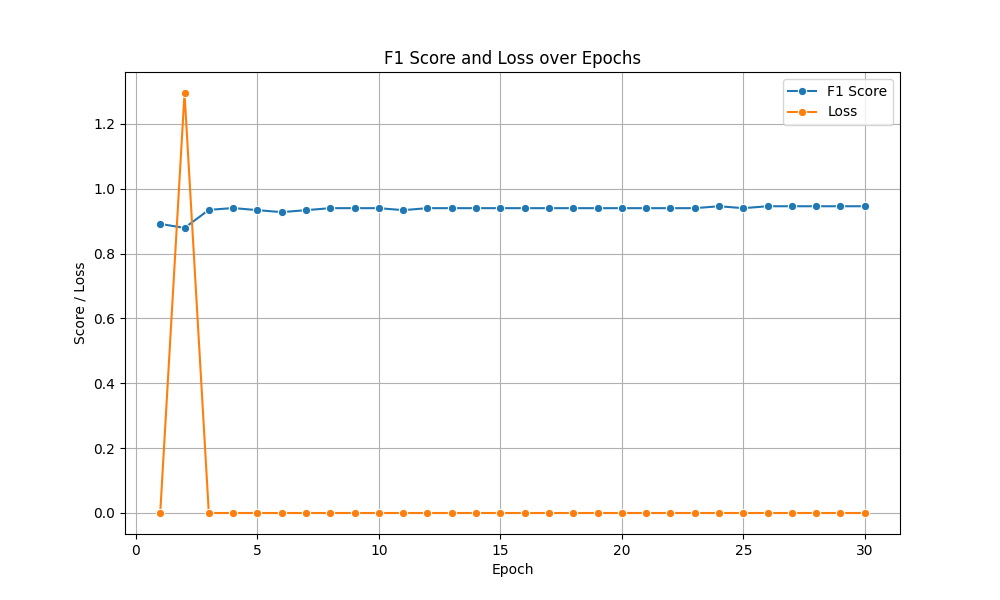

In [36]:
model.image

In [37]:
def pad_sequences(sequences, max_len):
        padded_sequences = cupy.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

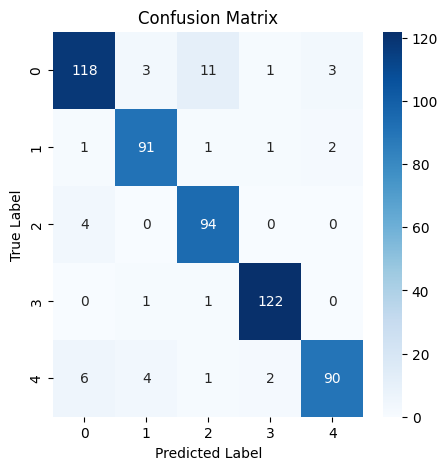

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

X_test= pad_sequences(X_test, max_words_per_phrase)

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test, axis=1) 
# Compute confusion matrix
cm = confusion_matrix(y_true.get(), y_pred.get(), labels=np.arange(5))

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
f1_score(y_pred.get(),y_true.get(),average="weighted")

0.9249295548073202

In [22]:
f1_score(y_pred.get(),y_true.get(),average=None)

array([0.891, 0.936, 0.904, 0.964, 0.912])

In [213]:
f1_score(y_pred,y_true,average=None)

array([0.808     , 0.76190476, 0.8       , 0.88311688, 0.81052632])

In [216]:
f1_score(y_pred,y_true,average=None)

array([0.82071713, 0.7816092 , 0.83937824, 0.89686099, 0.80874317])

In [219]:
f1_score(y_pred,y_true,average=None)

array([0.83464567, 0.82634731, 0.78974359, 0.88596491, 0.88888889])